In [25]:
import loop_utils as u
import pandas as pd
import metrics
import numpy as np
from recbole.config import Config
from recbole.data import data_preparation, create_dataset
from recbole.quick_start.quick_start import get_model, get_trainer

from recbole.trainer import Trainer
from preprocess import preprocess
import torch
from recbole.data import Interaction

import matplotlib.pyplot as plt

In [10]:
params ={'model': 'BPR',
 'data_path': '/Users/andreafrasson/Desktop/tesi/Feedback-Loop-for-POI-RS',
 'topk': 10,
 'use_gpu': True,
 'gpu_id': 0,
 'dataset': 'foursquare',
 'embedding_size': 64,
 'learning_rate': 0.0014441770317725243,
 'mlp_hidden_size': [128, 128],
 'train_batch_size': 2048,
 'eval_args': {
    'group_by': 'user',
    'order': 'TO', # temporal order
    'split': {'LS': 'valid_and_test'}, # leave one out
    'mode': 'full'}
}

In [3]:
# given a list of users, a matrix of items visited, the length and the model
# make the prediction for each user.
# Return only the 10 best items predicted for each user
def prediction(users, items, model):

    if torch.is_tensor(users):
        input_inter = Interaction({
            'uid': users,
            'venue_id': items.reshape(len(users), -1),
        })

    else:
        #make prediction for users
        input_inter = Interaction({
            'uid': torch.tensor(users),
            'venue_id': items.reshape(len(users), -1),
        })

    with torch.no_grad():
        scores = model.full_sort_predict(input_inter).reshape((len(users), -1))
    
    # get the 10 items with highest scores
    rec_list = np.argsort(scores, axis = 1)[:, -10:] - 1
    

    return rec_list


In [4]:
def update_interactions(new_items, training_set, validation_set):

    train_df = pd.read_csv('foursquare/foursquare.part1.inter', sep = ',')
    valid_df = pd.read_csv('foursquare/foursquare.part2.inter', sep = ',')

    new_train = pd.concat([train_df, valid_df]).sort_values(by = ['uid:token', 'timestamp:token'])
    new_train.to_csv('foursquare/foursquare.part1.inter', sep = ',', index=False)
    new_train.columns = ['uid', 'venue_id', 'timestamp']
    training_set._dataset.inter_feat = Interaction(new_train.copy())

    tokens = valid_df['uid:token'].to_numpy()
    timestamps = max(valid_df['timestamp:token'].to_numpy()) + 1
    
    new_val = pd.DataFrame(zip(tokens, [int(s) for s in new_items], [timestamps] * len(tokens)),
                columns=['uid', 'venue_id', 'timestamp'])
    new_val = new_val.sort_values(['uid', 'timestamp'])
    validation_set._dataset.inter_feat = Interaction(new_val.copy())

    new_val.columns = ['uid:token', 'venue_id:token', 'timestamp:token']
    new_val.to_csv('foursquare/foursquare.part2.inter', sep = ',', index=False)


In [ ]:
# make the first atomic files form the data
seed = 1234 # to get always the same users in train/test
preprocess()

#all users
train_users = pd.read_csv('foursquare/foursquare.part1.inter', sep = ',')['uid:token'].to_list()
train_users = list(set(train_users))


#hyperparameter tuning
#params = u.tuning('BPR', 'bpr.hyper', {'dataset': 'foursquare'})
config = Config(config_file_list=['foursquare_general.yaml'], config_dict = params)

m = 3
MaxIt = 20
c = 0

hit = []
prec = []
card = []
mean_entropy_train = []


while c < MaxIt:
    print('--------- iteration number: ', c)
    print('')

    if c % m == 0:  
        #create the dataset
        dataset = create_dataset(config)
        training_set, validation_set, test_set = data_preparation(config, dataset)

        model = get_model(config['model'])(config, training_set.dataset).to(config['device'])

        # trainer loading and initialization
        trainer = Trainer(config, model)
        # model training
        best_valid_score, best_valid_result = trainer.fit(training_set, validation_set)
        results = trainer.evaluate(test_set)

        hit.append(results['hit@10'])
        prec.append(results['precision@10'])

        print('Test error: ', results)

    # generate synthetic data for the training
    uid_series = training_set._dataset.token2id(training_set._dataset.uid_field, [str(s) for s in train_users])
    items = training_set._dataset.inter_feat[training_set._dataset.iid_field].reshape(len(train_users), -1)
    rec_list = prediction(uid_series, items, model)

    # translate the location id back to the original embedding
    external_item_list = dataset.id2token(dataset.iid_field, rec_list.cpu())
    # remove pad
    pad_indices = np.where(external_item_list == '[PAD]')[0]
    external_item_list = np.delete(external_item_list, pad_indices, axis = 1)

    card.append(len(external_item_list.reshape(1,-1).unique().detach().numpy()))

    # choose one item
    chosen_items = np.apply_along_axis(np.random.choice, 1, external_item_list)

    # update the training/validation file
    update_interactions(chosen_items, training_set, validation_set)
    entropy_train = metrics.uncorrelated_entropy(pd.read_csv('foursquare/foursquare.part1.inter', sep = ','))

    #entropy after the update in the interactions
    mean_entropy_train.append(np.mean(entropy_train['entropy'].to_numpy()))

    c+=1

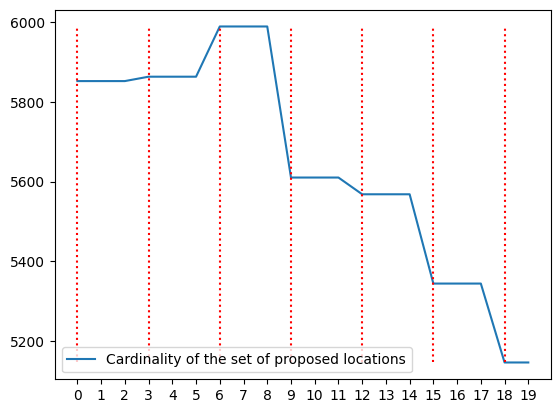

In [15]:
iterations = [i for i in range(MaxIt)]
plt.plot(iterations, card)
plt.xticks(range(MaxIt))
plt.vlines(np.arange(MaxIt, step=3), ymin=min(card), ymax= max(card), colors='red',linestyles='dotted')
plt.legend(['Cardinality of the set of proposed locations'], loc = 'lower left')
plt.show()

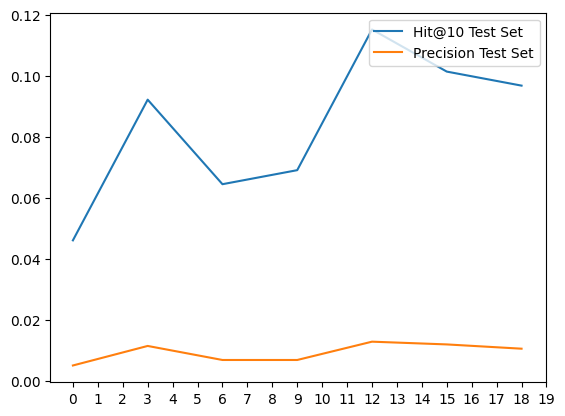

In [16]:
iterations = [i for i in np.arange(MaxIt, step = 3)]
plt.plot(iterations, hit)
plt.plot(iterations, prec)
plt.xticks(range(MaxIt))
plt.legend(['Hit@10 Test Set', 'Precision Test Set' ], loc = 'upper right')
plt.show()

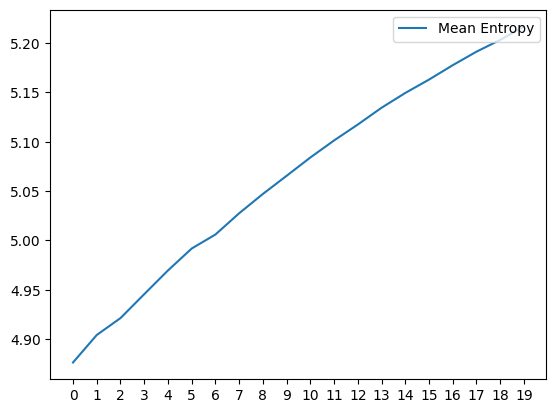

In [24]:
mean_entropy = [np.mean(i['entropy'].to_numpy()) for i in entropy]
plt.plot(iterations, mean_entropy)
plt.xticks(range(MaxIt))
plt.legend(['Mean Entropy'], loc = 'upper right')
plt.show()